## Ball Tracking
Outcome: y_positions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# Initialize variables
cap = cv2.VideoCapture("dataset/ball_8.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second: {int(fps)}")

lower_orange = np.array([5, 120, 120])  
upper_orange = np.array([25, 255, 255])  
y_positions = []  

sum_r = 0
avg_r = 0

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
    gray = cv2.GaussianBlur(cv2.bitwise_and(frame, frame, mask=mask), (9, 9), 2)
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 30, param1=50, param2=30, minRadius=5, maxRadius=50)

    if circles is not None:
        x, y, r = min(circles[0], key=lambda c: c[2])  
        y_positions.append(y)  
        sum_r += r

        # Draw detected ball
        cv2.circle(frame, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), 3)

    cv2.imshow("Ball Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Frames per second: 23


## Pixel to cm Conversion

In [2]:
# Calculate pixel to cm ratio
RADIUS_CM = 2

avg_r = sum_r / len(y_positions)
print(f"The average radius is {avg_r} pixels")

pixel_to_cm = RADIUS_CM / avg_r
print(f"The pixel to cm ratio is {pixel_to_cm} cm/pixel")

The average radius is 17.064285278320312 pixels
The pixel to cm ratio is 0.11720385402441025 cm/pixel


## Single Smoothing
Outcome: smoothed_y

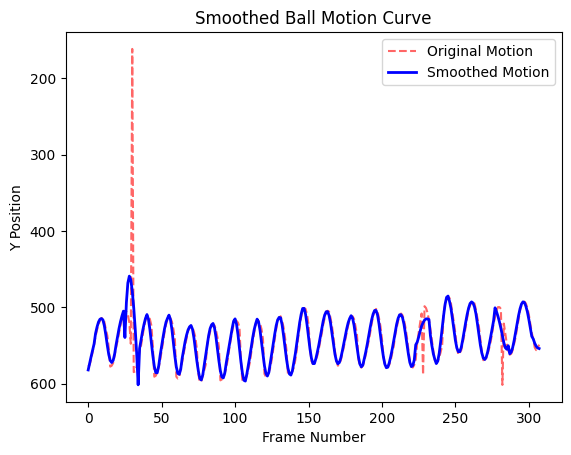

In [ ]:

if len(y_positions) > 5:  # Ensure enough data points for filtering
    smoothed_y = savgol_filter(y_positions, window_length=10, polyorder=2)
else:
    smoothed_y = y_positions  # Fallback if not enough points

# Plot motion curve
plt.plot(y_positions, label="Original Motion", color="red", linestyle="dashed", alpha=0.6)
plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
plt.xlabel("Frame Number")
plt.ylabel("Y Position")
plt.title("Smoothed Ball Motion Curve")
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis (since top is 0 in images)
plt.show()

## Calculate Compression Depth and Rate

In [4]:
# Find peaks (local maxima) in the smoothed signal
peaks_max = find_peaks(-smoothed_y, distance=10)  # Negative because higher y is downward
peaks_min = find_peaks(smoothed_y, distance=10) 
peaks = np.sort(np.concatenate((peaks_max[0], peaks_min[0])))

# Calculate motion frequency (rate)
if len(peaks_max[0]) > 1:
    # peak_to_peak_frames contains the difference in frame numbers between 2 conesecutive peaks
    peak_to_peak_frames = np.diff(peaks_max[0])  # Time between peaks in frames
    avg_peak_to_peak_frames = np.mean(peak_to_peak_frames)  # Average period in frames
    avg_period_seconds = avg_peak_to_peak_frames / fps  # Convert to seconds
    frequency_hz = 1 / avg_period_seconds  # Convert period to frequency
else:
    frequency_hz = None
    avg_peak_to_peak_frames = None

# Calculate depth of motion (peak-to-peak distance)
if len(peaks) > 1:
    compression_depth_px = np.diff(smoothed_y[peaks])  # Distance between peaks in pixels
    compression_depth_px = np.abs(compression_depth_px)
    avg_compression_depth_px= np.mean(compression_depth_px)  # Average depth in pixels
    avg_compression_depth_cm = avg_compression_depth_px * pixel_to_cm  # Convert to cm  

# Print extracted values
print(f"Motion Frequency: {frequency_hz:.2f} Hz" if frequency_hz else "Not enough peaks detected")
print(f"Average Compression Depth: {avg_compression_depth_cm:.2f} cm" if avg_compression_depth_cm else "Not enough peaks detected")

Motion Frequency: 1.50 Hz
Average Compression Depth: 8.84 cm


## Display Peaks

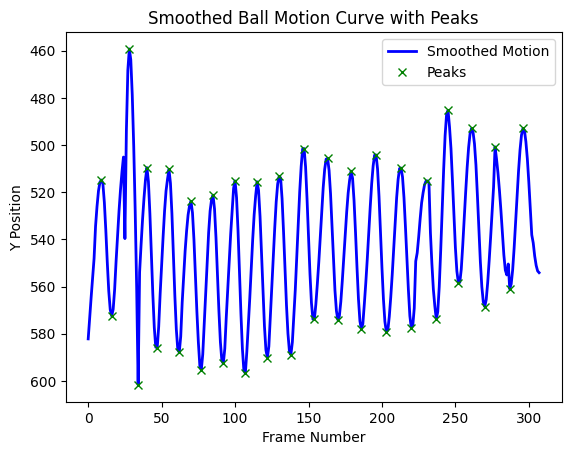

In [5]:
# Plot the peaks on the motion curve
plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
plt.plot(peaks, smoothed_y[peaks], "x", label="Peaks", color="green")
plt.xlabel("Frame Number")
plt.ylabel("Y Position")
plt.title("Smoothed Ball Motion Curve with Peaks")
plt.legend()
plt.gca().invert_yaxis()
plt.show()